# **DEPENDENCIES**

In [222]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

In [ ]:
from google.colab import drive; drive.mount("/content/drive")

# **DATASET**

In [294]:
def create_dataset(faces_dataset_path):
    train_images = []
    train_labels = []
    val_images = []
    val_labels = []
    test_images = []
    test_labels = []

    class_labels = os.listdir(faces_dataset_path)
    num_classes = len(class_labels)

    for class_idx, folder in enumerate(tqdm(class_labels)):
        folder_path = os.path.join(faces_dataset_path, folder)
        images = os.listdir(folder_path)
        np.random.shuffle(images)
        num_images = len(images)

        for i, file in enumerate(images):
            img = cv2.imread(os.path.join(folder_path, file))
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            if i < 0.7 * num_images:
                train_images.append(img)
                train_labels.append(class_idx)
            elif i < 0.85 * num_images:
                val_images.append(img)
                val_labels.append(class_idx)
            else:
                test_images.append(img)
                test_labels.append(class_idx)

    return (
        np.array(train_images), np.array(train_labels),
        np.array(val_images), np.array(val_labels),
        np.array(test_images), np.array(test_labels)
    )

### **Faces Dataset**   
Description: 9 different people. 128 x 128 images

In [299]:
faces_dataset_path = "/content/drive/MyDrive/data_assn2_cv/actors/faces"
Xtrf, Ytrf, Xvaf, Yvaf, Xtef, Ytef = create_dataset(faces_dataset_path)

100%|██████████| 9/9 [00:04<00:00,  2.12it/s]


### **Cifar10 Dataset**  
Description:
1. Using Cifar10 for non-human objects. These images are 32 x 32, but it won't be a problem since the histograms will be normalized.
2. For grayscaling, I use the formula $Gr = 0.3R + 0.59G + 0.11B$ as per the following blog (Did this to avoid using cv2 loops):  
[Colour to Grayscale](https://www.baeldung.com/cs/convert-rgb-to-grayscale)

In [83]:
(Xtrc, Ytrc), (Xtec, Ytec) = tf.keras.datasets.cifar10.load_data()
Xtrc = np.dot(Xtrc, [0.3, 0.59, 0.11]).astype(int)
Xtec = np.dot(Xtec, [0.3, 0.59, 0.11]).astype(int)

# **HLBP**  
### Local Binary Pattern (LBP) Computation

The `compute_lbp` function takes an input grayscale image, `radius`, and `npoints`. It calculates LBP values for each pixel, encoding local texture patterns based on comparisons with neighboring pixels. The output is an LBP image.

### Formula

For each pixel (i, j):

- `center` is the intensity value of the center pixel.
- `x_offsets` and `y_offsets` represent sample point positions relative to the center.
- `pattern` is a binary pattern encoding relationships between the center and its neighbors.
- LBP value is stored in the output LBP image at (i, j).


In [134]:
def compute_lbp(images, radius=1, npoints=8, axis=0):
    if axis not in [0, 1]:
        raise ValueError(
            "Axis must be 0 or 1 for row-wise or column-wise processing."
        )

    num_images, height, width = images.shape
    lbp_images = np.zeros(images.shape, dtype=np.uint8)

    angles = np.linspace(0, 2 * np.pi, npoints, endpoint=False)
    x_offsets = np.round(radius * np.cos(angles)).astype(int)
    y_offsets = np.round(radius * np.sin(angles)).astype(int)

    for i in range(radius, height - radius):
        for j in range(radius, width - radius):
            center = images[:, i, j] if axis == 0 else images[i, j, :]
            pattern = np.zeros(num_images, dtype=np.uint8)
            for x_offset, y_offset in zip(x_offsets, y_offsets):
                x = i + x_offset
                y = j + y_offset
                neighbor = images[:, x, y] if axis == 0 else images[x, y, :]
                pattern = (pattern << 1) | (neighbor >= center)
            lbp_images[:, i, j] = pattern

    return lbp_images

In [126]:
def plot_lbp(original_images, lbp_images):
    num_images = len(original_images)
    fig, axs = plt.subplots(2, num_images, figsize=(3 * num_images, 6))
    plt.tight_layout(pad=0.0)
    for i in range(num_images):
        axs[0, i].imshow(original_images[i], cmap='gray')
        axs[0, i].set_title('Original')
        axs[0, i].axis('off')

        axs[1, i].imshow(lbp_images[i], cmap='gray')
        axs[1, i].set_title('LBP')
        axs[1, i].axis('off')
    plt.show()

### Plot of Original vs LBP images

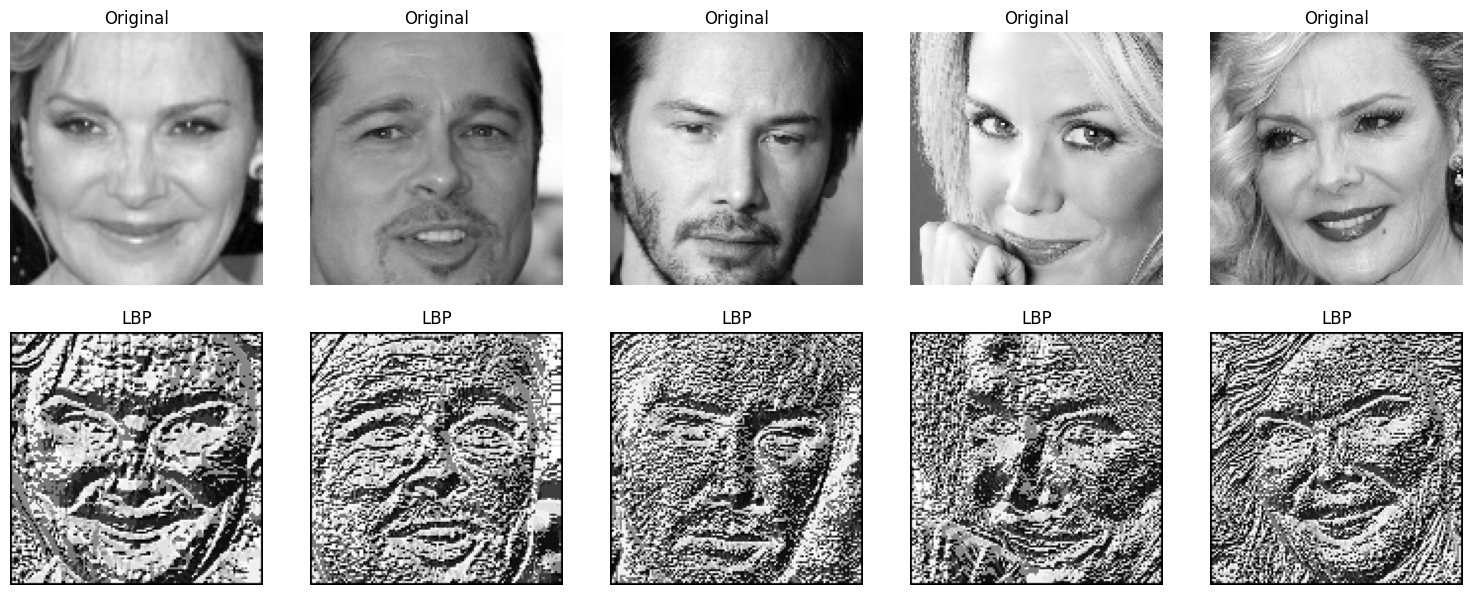

In [281]:
S = Xtrf[np.random.randint(0, Xtrf.shape[0], 5)]; plot_lbp(S, compute_lbp(S))

### Compute Histograms of LBP

In [161]:
def compute_hist(images):
    images = images.reshape(images.shape[0], -1)
    bins = np.arange(-0.5, 255.5, 1)
    hist = np.apply_along_axis(
        lambda x: np.histogram(x, bins=bins)[0], 1, images
    ).astype('float')
    hist /= np.linalg.norm(hist, axis=1, keepdims=True)
    return hist

In [300]:
Xtrfh = compute_hist(Xtrf)
Xtefh = compute_hist(Xtef)
Xvafh = compute_hist(Xvaf)

# **KNN**

In [290]:
class KNNClassifier():
    def __init__(self, K, metric='euclidean'):
        self.K = K
        self.metric = metric
        self.inv_mcm = None

    @staticmethod
    def mode(arr):
        unique, counts = np.unique(arr, return_counts=True)
        return unique[np.argmax(counts)]

    def euclidean_distance(self, x):
        return np.sqrt(np.sum((self.X - x) ** 2, axis=1))

    def manhattan_distance(self, x):
        return np.sum(np.abs(self.X - x), axis=1)

    def chebyshev_distance(self, x):
        return np.max(np.abs(self.X - x), axis=1)

    def mahalanobis_distance(self, x):
        if self.inv_mcm is None:
            raise ValueError("Covariance matrix is not available.")
        diff = self.X - x
        distances = np.sqrt(np.sum(np.dot(diff, self.inv_mcm) * diff, axis=1))
        return distances

    def minkowski_distance(self, x, p=2):
        return np.power(np.sum(np.power(np.abs(self.X - x), p), axis=-1), 1/p)

    def cosine_distance(self, x):
        dot_product = np.dot(self.X, x)
        norm_x = np.linalg.norm(x)
        norm_data = np.linalg.norm(self.X, axis=1)
        cosine_sim = dot_product / (norm_x * norm_data)
        cosine_distance = 1 - cosine_sim
        return cosine_distance

    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.m, self.n = X.shape

        if self.metric == 'mahalanobis':
            mah_covariance_matrix = np.cov(X, rowvar=False, bias=True)
            self.inv_mcm = np.linalg.inv(mah_covariance_matrix)

    def predict(self, X):
        self.X_test = X
        self.m_test, _ = X.shape
        Y_predict = np.zeros(self.m_test)

        for i in range(self.m_test):
            x = X[i]
            neighbors = self.find_neighbors(x)
            Y_predict[i] = self.mode(neighbors)

        return Y_predict

    def find_neighbors(self, x):
        if self.metric == 'mahalanobis':
            distances = self.mahalanobis_distance(x)
        elif self.metric == 'euclidean':
            distances = self.euclidean_distance(x)
        elif self.metric == 'manhattan':
            distances = self.manhattan_distance(x)
        elif self.metric == 'chebyshev':
            distances = self.chebyshev_distance(x)
        elif self.metric == 'minkowski':
            distances = self.minkowski_distance(x)
        elif self.metric == 'cosine':
            distances = self.cosine_distance(x)

        inds = distances.argsort()
        Y_sorted = self.Y[inds]
        return Y_sorted[:self.K]

    def score(self, X_test, Y_true):
        Y_pred = self.predict(X_test)
        accuracy = np.mean(Y_pred == Y_true)
        return accuracy

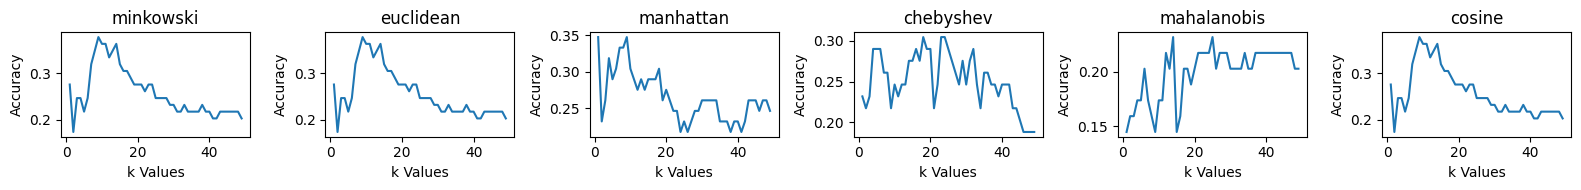

Best KNN model on validation data: K=9, metric-minkowski: Score (Val acc)=0.37681159420289856
Accuracy on train data: 0.4458204334365325
Accuracy on val data: 0.37681159420289856
Accuracy on test data: 0.3230769230769231


In [301]:
k_values = range(1, 50)
distance_metrics = ['minkowski', 'euclidean', 'manhattan', 'chebyshev', 'mahalanobis', 'cosine']
best_model = None
best_score = 0
fig, axes = plt.subplots(1, 6, figsize=(16, 2))
for j, distance_metric in enumerate(distance_metrics):
    accuracy_values = []
    for k in k_values:
        knn = KNNClassifier(k, metric=distance_metric)
        knn.fit(Xtrfh, Ytrf)
        accuracy = knn.score(Xvafh, Yvaf)
        if accuracy > best_score:
            best_model = knn
            best_score = accuracy
        accuracy_values.append(accuracy)
    ax = axes[j]
    ax.plot(k_values, accuracy_values)
    ax.set_xlabel('k Values')
    ax.set_ylabel('Accuracy')
    ax.set_title(distance_metric)
plt.tight_layout()
plt.show()
print(f"Best KNN model on validation data: K={best_model.K}, metric-{best_model.metric}: Score (Val acc)={best_score}")
print(f"Accuracy on train data: {best_model.score(Xtrfh, Ytrf)}")
print(f"Accuracy on val data: {best_model.score(Xvafh, Yvaf)}")
print(f"Accuracy on test data: {best_model.score(Xtefh, Ytef)}")

# **SVM**

In [266]:
from sklearn import svm

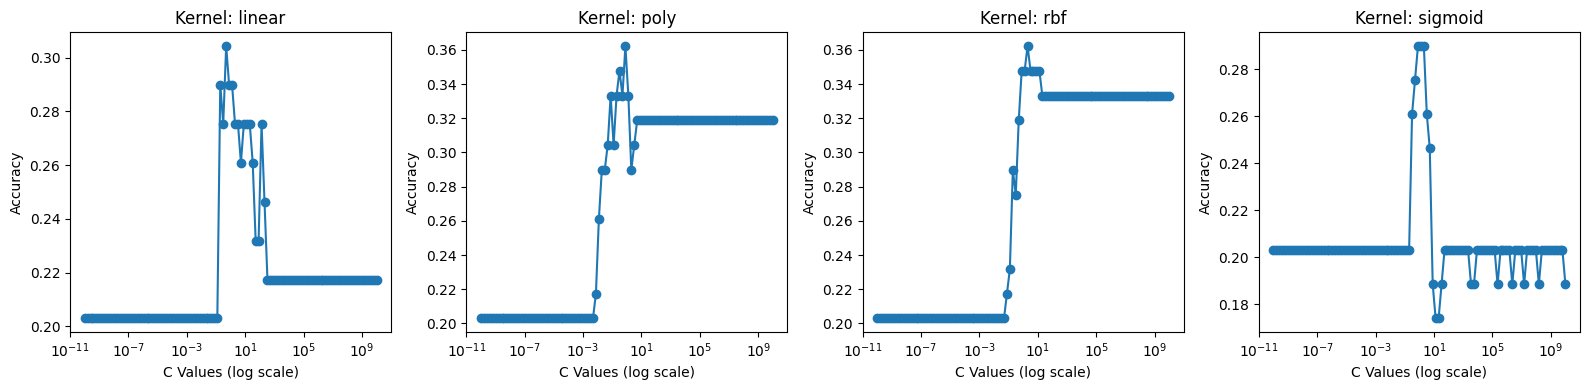

Best SVM model on validation data: C=0.7924828983539186, kernel-poly | Accuracy = 0.36231884057971014
Accuracy on train data: 0.8606811145510835
Accuracy on val data: 0.36231884057971014
Accuracy on test data: 0.3076923076923077


In [303]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = np.logspace(-10, 10, 50)
degree = np.arange(10)
best_model = None
best_score = 0

fig, axes = plt.subplots(1, len(kernels), figsize=(16, 4))

for i, kernel in enumerate(kernels):
    accuracy_values = []
    for C in C_values:
        svm_classifier = svm.SVC(kernel=kernel, C=C, decision_function_shape='ovr')
        svm_classifier.fit(Xtrfh, Ytrf)
        accuracy = svm_classifier.score(Xvafh, Yvaf)
        if accuracy > best_score:
            best_model = svm_classifier
            best_score = accuracy
        accuracy_values.append(accuracy)
    ax = axes[i]
    ax.plot(C_values, accuracy_values, marker='o')
    ax.set_xscale('log')
    ax.set_xlabel('C Values (log scale)')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Kernel: {kernel}')
plt.tight_layout()
plt.show()
print(f"Best SVM model on validation data: C={best_model.C}, kernel-{best_model.kernel} | Accuracy = {best_score}")
print(f"Accuracy on train data: {best_model.score(Xtrfh, Ytrf)}")
print(f"Accuracy on val data: {best_model.score(Xvafh, Yvaf)}")
print(f"Accuracy on test data: {best_model.score(Xtefh, Ytef)}")

SVM better fit the train and validation data

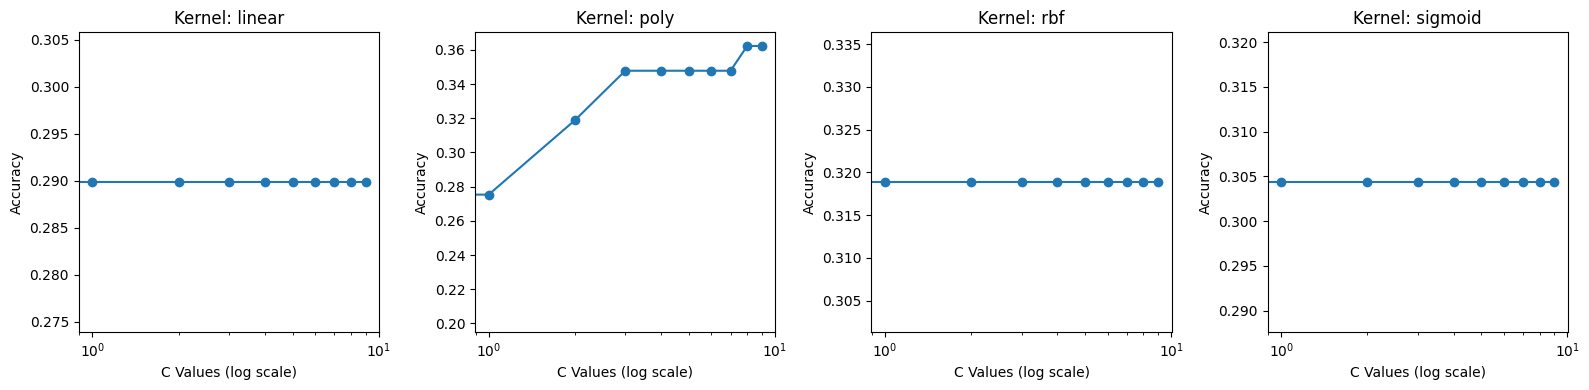

Best SVM model on validation data: d=8, kernel-poly | Accuracy = 0.36231884057971014
Accuracy on train data: 1.0
Accuracy on val data: 0.36231884057971014
Accuracy on test data: 0.2923076923076923


In [306]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = np.arange(10)
best_model = None
best_score = 0

fig, axes = plt.subplots(1, len(kernels), figsize=(16, 4))

for i, kernel in enumerate(kernels):
    accuracy_values = []
    for d in degrees:
        svm_classifier = svm.SVC(kernel=kernel, degree=d, decision_function_shape='ovr')
        svm_classifier.fit(Xtrfh, Ytrf)
        accuracy = svm_classifier.score(Xvafh, Yvaf)
        if accuracy > best_score:
            best_model = svm_classifier
            best_score = accuracy
        accuracy_values.append(accuracy)
    ax = axes[i]
    ax.plot(degrees, accuracy_values, marker='o')
    ax.set_xscale('log')
    ax.set_xlabel('C Values (log scale)')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Kernel: {kernel}')
plt.tight_layout()
plt.show()
print(f"Best SVM model on validation data: d={best_model.degree}, kernel-{best_model.kernel} | Accuracy = {best_score}")
print(f"Accuracy on train data: {best_model.score(Xtrfh, Ytrf)}")
print(f"Accuracy on val data: {best_model.score(Xvafh, Yvaf)}")
print(f"Accuracy on test data: {best_model.score(Xtefh, Ytef)}")

Since higher degrees were allowed in this case, polynomial kernel quickly overfit the data